In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import glob
import os
from tqdm import tqdm

In [2]:
directories = {
    'average': 'npy_results/average/',
    'deepmil_multi': 'npy_results/deepmil_multi/',
    'gradcampp': 'npy_results/gradcampp/',
    'lse': 'npy_results/lse/',
    'max': 'npy_results/max/',
    'wildcat': 'npy_results/wildcat/'
}

In [3]:
def get_overlays_and_dice(path):
    paths = glob.glob(path + '*.pkl')
    
    print(paths)
    overlays = None
    dices = None
    
    for p in paths:
        with open(p, 'rb') as f:
            pickle_obj = pickle.load(f)
            
        if 'dices' in p:
            dices = pickle_obj
        elif 'overlays' in p:
            overlays = pickle_obj
            overlays = [item.transpose(1, 2, 0) for item in overlays]
    return overlays, dices

In [4]:
results = {method: get_overlays_and_dice(directory) for (method, directory) in zip(directories.keys(), directories.values())}

['npy_results/average/average_dices.pkl', 'npy_results/average/average_overlays.pkl']
['npy_results/deepmil_multi/deepmil_multi_overlays.pkl', 'npy_results/deepmil_multi/deepmil_multi_dices.pkl']
['npy_results/gradcampp/gradcampp_overlays.pkl', 'npy_results/gradcampp/gradcampp_dices.pkl']
['npy_results/lse/lse_dices.pkl', 'npy_results/lse/lse_overlays.pkl']
['npy_results/max/max_dices.pkl', 'npy_results/max/max_overlays.pkl']
['npy_results/wildcat/wildcat_dices.pkl', 'npy_results/wildcat/wildcat_overlays.pkl']


In [5]:
# sanity check
for method in results.keys():
    print(method, results[method][1].mean())

average 0.668309804610908
deepmil_multi 0.7130869656801224
gradcampp 0.660151631757617
lse 0.6710637575015426
max 0.6501594597473741
wildcat 0.6647139986976981


In [6]:
# Input and GT
with open('npy_results/overlay_gt/input.pkl', 'rb') as f:
    img_input = pickle.load(f)
    img_input = [item.squeeze().transpose(1, 2, 0) for item in img_input]
with open('npy_results/overlay_gt/gt_overlays.pkl', 'rb') as f:
    gt_overlay = pickle.load(f)
    gt_overlay = [item.transpose(1, 2, 0) for item in gt_overlay]

In [7]:
len(img_input), img_input[0].shape

(80, (522, 775, 3))

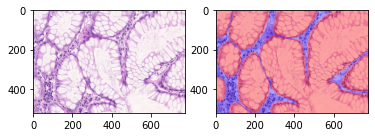

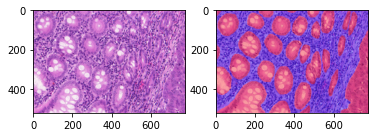

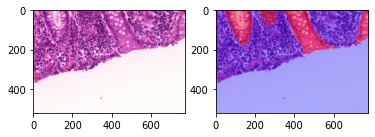

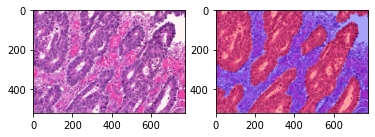

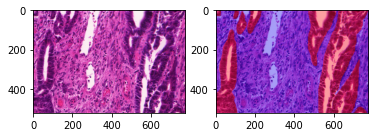

In [8]:
for i in range(5):
    img = img_input[i]
    over = gt_overlay[i]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax2.imshow(over)

In [9]:
fig_dir = 'result_figs/'
for i in tqdm(range(len(img_input)), ncols=80, desc='Saving figures'):
    fig, axs = plt.subplots(1, len(results.keys())+2, sharey='row', gridspec_kw={'wspace': 0.01}, figsize=(30,5))
    (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = axs
    
    ax0.imshow(img_input[i])
    ax0.set_title('Input')
    ax0.axis('off')
    
    ax1.imshow(gt_overlay[i])
    ax1.set_title('GT overlay')
    ax1.axis('off')
    
    result_axes = [ax2, ax3, ax4, ax5, ax6, ax7]
    for method, axis in zip(results.keys(), result_axes):
        overlays, dices = results[method]
        axis.imshow(overlays[i])
        axis.set_title('{} (Dice: {})'.format(method, round(dices[i], 4)))
        axis.axis('off')
    
    f_name = 'results_{}.png'.format(i)
    f_path = os.path.join(fig_dir, f_name)
    plt.savefig(f_path, dpi=150)
    plt.close(fig)

Saving figures: 100%|███████████████████████████| 80/80 [01:43<00:00,  1.29s/it]
